# Importa mallas

En este jupyter notebook mostramos como convertir mallas para importarlas en Python y que podrán ser utilizadas en FEniCS (el software de elementos finitos que utilizaremos).

Si se desea ejecutar localmente esta jupyter notebook se deben tener instalados los siguientes programas:

- Python 3.5 o más nuevo instalado.
- [Jupyter Notebook](https://jupyter.readthedocs.io/en/latest/install.html).
- [FEniCS](https://fenicsproject.org/).
- [Meshio](https://pypi.org/project/meshio/)
- [Gmsh](https://gmsh.info/)

En google colab necesitaremos instalar las herramientas necesarias previamente.

Primero vamos con FEniCS, la solución la sacamos de este [sitio](https://fem-on-colab.github.io/).

In [1]:
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

Ahora seguimos con meshio, que es un software desarrollado por la misma gente de FEniCS y algunos más que permite construir mallas y convertirlas a diferentes formatos (también de los softwares de FEM comerciales).

In [4]:
%%capture
pip install meshio

## Convierte de .msh a .xmdf

Cuando creamos una malla con Gmsh obtenemos un archivo de formato .msh, que contiene toda la información de los triangulos (o tetraedros), los subdominios físicos y los contornos (bordes) físicos también. No solo debe tener la ubicación de los nodos y sus conexiones, sino también de cada uno de los triangulos y las marcas (tags) que definimos oportunamente.

Como se comentó debemos dar información de la malla a FEniCS. Actualmente, esto se hace con un formato para manejar grillas y geometrías 2D y 3D de manera muy eficiente con extensión [xmdf](https://www.xmswiki.com/wiki/XMDF), que maneja datos de formato [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) (Hierarchical Data Format). Esto involucra un software denominado **meshio** que permite convertir diferentes formatos de mallas para ser importados en FEniCS (incluso mallas de software comercial como ANSYS y otros).

Comenzaremos subiendo al repositorio un malla ejemplo de Gmsh. En nuestro caso la llamamos *geometria2D.geo*, al ejecutar:

gmsh -2 geometria2D.geo

se creó un archivo *geometria2D.msh* y este es el que utilizaremos para convertir a xmdf y luego pasar a FEniCS. Recuerden subir el archivo al Google Colab.

Primero importo las herramientas necesarias:

In [6]:
from dolfin import *
import meshio
import numpy as np

Luego importo el archivo .msh y creo un objeto meshio que contiene toda la información de la malla. Imprimo para ver de qué se trata.

In [8]:
#Primera parte convierte .msh a xdmf
nombre_malla = 'geometria2D'
msh = meshio.read(nombre_malla+'.msh')
print(msh)


<class 'meshio._mesh.Mesh'>
<meshio mesh object>
  Number of points: 142
  Number of cells:
    line: 10
    triangle: 242
  Cell data: gmsh:physical, gmsh:geometrical


Ahora utilizando la función de numpy [vstack](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html) voy apilando todos los **triangulos** (note que pusimos *triangle*). 

In [9]:
points = msh.points
points = points[:,:2]
cells = np.vstack([cells.data for cells in msh.cells if cells.type == "triangle"])
cell_data = np.vstack([msh.cell_data_dict["gmsh:physical"][key] for key in msh.cell_data_dict["gmsh:physical"].keys() if key =="triangle"])
mesh_new = meshio.Mesh(points=points, cells=[("triangle", cells)], cell_data={"name_to_read": cell_data})
meshio.write(nombre_malla+".xdmf", mesh_new)


De la misma forma levanto los **bordes** (note que en caso de 2D son lineas *line*).

In [10]:
facet_cells = np.vstack([cells.data for cells in msh.cells if cells.type == "line"])
facet_data = np.vstack([msh.cell_data_dict["gmsh:physical"][key] for key in msh.cell_data_dict["gmsh:physical"].keys() if key == "line"])
facet_mesh = meshio.Mesh(points=points,cells=[("line", facet_cells)],cell_data={"name_to_read": facet_data})
meshio.write(nombre_malla+"_bordes.xdmf", facet_mesh)



Entonces hasta ahora hemos hemos convertido tanto los triangulos como los bordes marcados en dos archivos que se llaman del mismo nombre que el original, con extensión *.xmdf* y *_bordes.xmdf* los que contienen el dominio y bordes, respectivamente. Noten que además se crean archivos con extensión .h5, éstos tienen la información numérica guardada de una manera compacta.

Lo que sigue es pasarlo a FEniCS, pero eso lo entenderemos más adelante, ahora lo hacemos solo para graficar la malla en python y para mostrar que el ejemplo funciona.

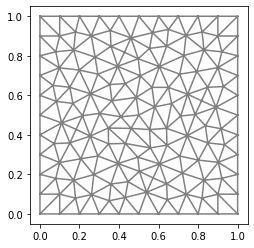

In [11]:
mesh = Mesh()

#Ahora levanta el xdmf de los dominios
with XDMFFile(nombre_malla+".xdmf") as infile:
    infile.read(mesh)
    mvcv = MeshValueCollection("size_t", mesh, mesh.topology().dim())
    infile.read(mvcv, "name_to_read")

subdomains = cpp.mesh.MeshFunctionSizet(mesh, mvcv)

mvc = MeshValueCollection("size_t", mesh, mesh.topology().dim()-1)

#Ahora levanta el xdmf de los bordes
with XDMFFile(nombre_malla+"_bordes.xdmf") as infile:
    infile.read(mvc, "name_to_read")

boundaries = cpp.mesh.MeshFunctionSizet(mesh, mvc)

n = FacetNormal(mesh)
V = VectorFunctionSpace(mesh, 'CG', degree=2)


import matplotlib.pyplot as plt

plt.figure(1)
plot(mesh)

plt.show()


## Otra forma **obsoleta**: convirtiendo .msh a .xml

Hace unos años, y todavía funciona, se podía importar mallas con otro formato [*.xml*](https://en.wikipedia.org/wiki/XML) utilizando una herramienta que viene con FEniCS que se llama **dolfin-convert**. Esta herramienta, si bien sigue estando en FEniCS, es obsoleta y se sugiere fuertemente que se utilice el formato *xmdf*.

En consola, se debe ejecutar de la siguiente manera. Se transforma el .msh a un archivo que contiene la malla en formato .xml:

In [12]:
%%bash
dolfin-convert geometria2D.msh geometria2D.xml

Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 142 vertices
Found all vertices
Expecting 242 cells
Found all cells
Conversion done


Notar que aparecen tres archivos: nombre+.xml, nombre+_physical_region.xml, y nombre+_facet_region.xml. Estos tres archivos tienen: malla, subdominios, y bordes, respectivamente.

Luego para introducirlos a python y FEniCS se necesitan las siguientes lineas:

In [14]:
mesh2 = Mesh(nombre_malla+".xml");
subdomains2 = MeshFunction('size_t',mesh2,nombre_malla+"_physical_region.xml");
boundary_markers2 = MeshFunction('size_t',mesh2,nombre_malla+"_facet_region.xml");

Luego se puede graficar, de la misma forma que hicimos antes.

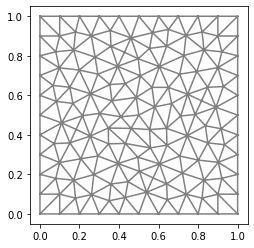

In [15]:
plt.figure(2)
plot(mesh2)
plt.show()